# Initial NdLinear Exploration

In [53]:
# Import the NdLinear implementation
from NdLinear.ndlinear import NdLinear
import torch
import torch.nn as nn

# Create a simple example showing how NdLinear preserves structure
input_tensor = torch.randn(32, 3, 224, 224)  # Batch x Channels x Height x Width

# Standard approach flattens the tensor
flattened = input_tensor.view(32, -1)  # Shape: [32, 150528]
linear = nn.Linear(3*224*224, 1000)
linear_output = linear(flattened)  # Shape: [32, 1000]

# NdLinear preserves the structure
ndlinear = NdLinear(input_dims=(3, 224, 224), hidden_size=(64, 16, 16))
ndlinear_output = ndlinear(input_tensor)  # Shape: [32, 64, 16, 16]

# Compare parameter counts
print(f"Linear parameters: {sum(p.numel() for p in linear.parameters())}")
print(f"NdLinear parameters: {sum(p.numel() for p in ndlinear.parameters())}")

Linear parameters: 150529000
NdLinear parameters: 7456


In [54]:

# Create sample data with multidimensional structure (like an image)
batch_size = 2
channels = 3
height = 32
width = 32

# Create a random tensor with image-like structure
x = torch.randn(batch_size, channels, height, width)
print(f"Input shape: {x.shape}")

# Create a standard linear layer (requires flattening)
flat_features = channels * height * width
linear_layer = nn.Linear(flat_features, 10)

# Apply standard linear layer (requires flattening first)
x_flat = x.view(batch_size, -1)
linear_output = linear_layer(x_flat)
print(f"Linear layer output shape: {linear_output.shape}")
print(f"Linear layer parameters: {sum(p.numel() for p in linear_layer.parameters())}")

# Create an NdLinear layer preserving structure
ndlinear_layer = NdLinear(
    input_dims=[channels, height, width],  # Input dimensions 
    hidden_size=[10, 1, 1]  # Output dimensions (10 classes, collapsed spatial dims)
)

# Apply NdLinear directly to structured input
ndlinear_output = ndlinear_layer(x)
print(f"NdLinear layer output shape: {ndlinear_output.shape}")
print(f"NdLinear layer parameters: {sum(p.numel() for p in ndlinear_layer.parameters())}")



Input shape: torch.Size([2, 3, 32, 32])
Linear layer output shape: torch.Size([2, 10])
Linear layer parameters: 30730
NdLinear layer output shape: torch.Size([2, 10, 1, 1])
NdLinear layer parameters: 106


## Basic MedMnist Classification comparision


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import medmnist
from medmnist import INFO 


from NdLinear.ndlinear import NdLinear


torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [56]:
batch_size = 2
channels = 3
height = 28
width = 28

input_tensor = torch.randn(batch_size, channels, height, width)  # Batch x Channels x Height x Width
print(f"Input shape: {input_tensor.shape}")


flattened = input_tensor.reshape(batch_size, -1)  # Shape: [2, 3*28*28]
linear = nn.Linear(channels * height * width, 64)
linear_output = linear(flattened)  # Shape: [2, 64]
print(f"Linear output shape: {linear_output.shape}")
print(f"Linear parameters: {sum(p.numel() for p in linear.parameters())}")

Input shape: torch.Size([2, 3, 28, 28])
Linear output shape: torch.Size([2, 64])
Linear parameters: 150592


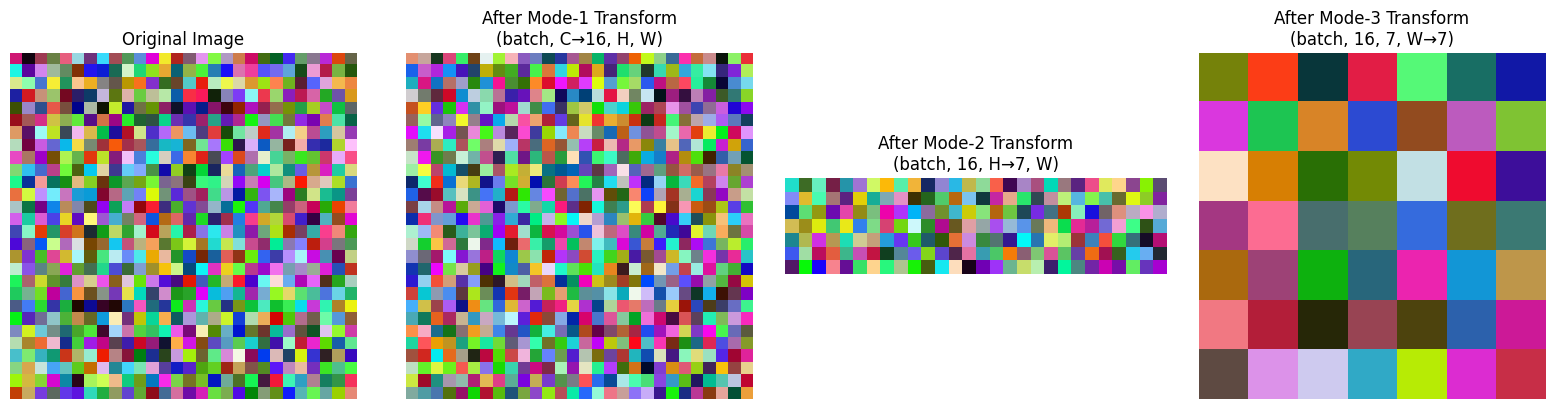

In [57]:
def visualize_ndlinear_transformation():
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(np.random.rand(28, 28, 3))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(np.random.rand(16, 28, 28).transpose(1, 2, 0)[:, :, :3])
    axs[1].set_title('After Mode-1 Transform\n(batch, C→16, H, W)')
    axs[1].axis('off')

    axs[2].imshow(np.random.rand(16, 7, 28).transpose(1, 2, 0)[:, :, :3])
    axs[2].set_title('After Mode-2 Transform\n(batch, 16, H→7, W)')
    axs[2].axis("off")

    axs[3].imshow(np.random.rand(16, 7, 7).transpose(1, 2, 0)[:, :, :3])
    axs[3].set_title('After Mode-3 Transform\n(batch, 16, 7, W→7)')
    axs[3].axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_ndlinear_transformation()



Dataset: pathmnist
Task: multi-class
Number of classes: 9
Number of channels: 3


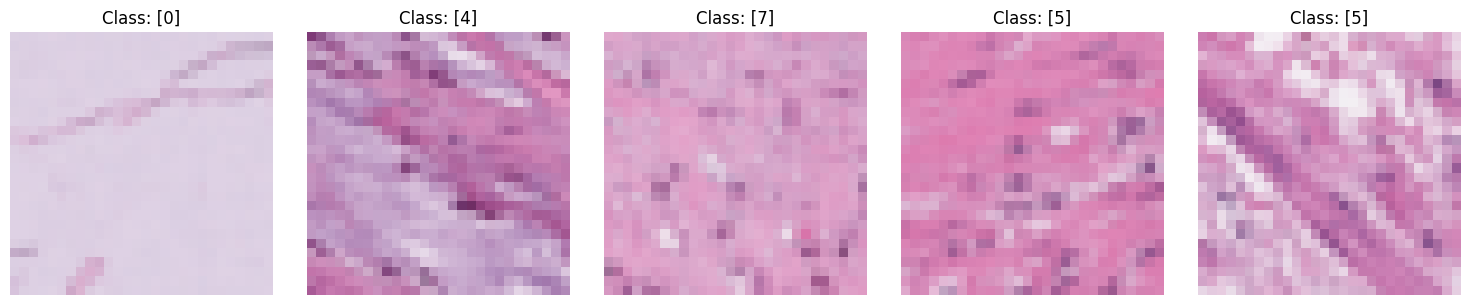

In [58]:
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
n_classes = len(info['label'])
n_channels = info['n_channels']
task = info['task']

print(f"Dataset: {data_flag}")
print(f"Task: {task}")
print(f"Number of classes: {n_classes}")
print(f"Number of channels: {n_channels}")

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_dataset = medmnist.dataset.PathMNIST(root='./data', split='train', transform=data_transform, download=download)
test_dataset = medmnist.dataset.PathMNIST(root='./data', split='test', transform=data_transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Visualize some sample images
def plot_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img, label = dataset[i]
        img = img.numpy().transpose((1, 2, 0))
        plt.imshow(img * 0.5 + 0.5)
        plt.title(f"Class: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_dataset)

In [59]:
import math

class TraditionalCNN(nn.Module):
    def __init__(self):
        super(TraditionalCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    

class NdLinearCNN(nn.Module):
    def __init__(self, input_shape, hidden_size):
        super(NdLinearCNN, self).__init__()
        # Convolutional layers (same as traditional CNN)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        final_dim = math.prod(hidden_size) 
        # NdLinear layers instead of fully connected
        self.ndlinear = NdLinear(input_dims=(64, 7, 7), hidden_size=hidden_size)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(final_dim, 100)

        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.ndlinear(x)
        # NdLinear transformation (no need to flatten)
        x = x.view(x.shape[0], -1)
        # Reshape to remove extra dimensions
        x = self.fc_out(self.relu(x))
        return x
 


traditional_model = TraditionalCNN().to(device)
ndlinear_model = NdLinearCNN((3, 32, 32), (64, 8, 8)).to(device)

Traditional CNN parameters: 422,089
NdLinear CNN parameters: 433,380
Parameter reduction: -2.68%


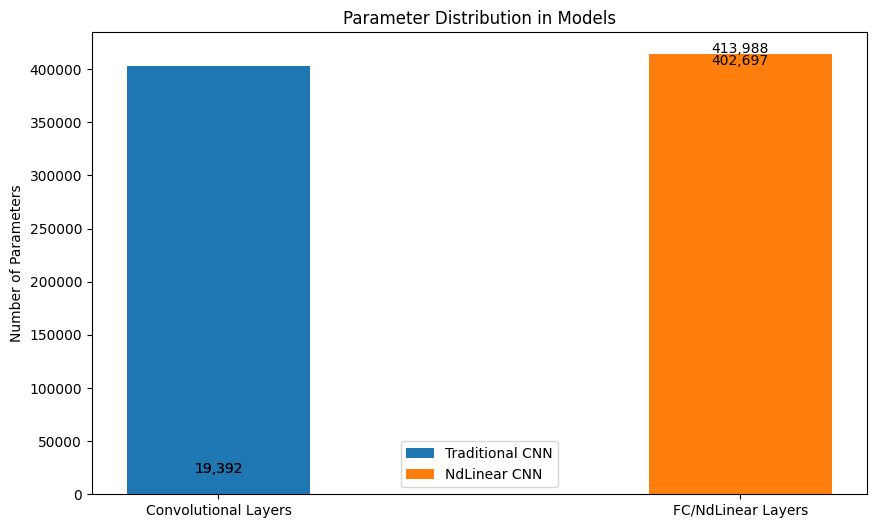

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Traditional CNN parameters: {count_parameters(traditional_model):,}")
print(f"NdLinear CNN parameters: {count_parameters(ndlinear_model):,}")
print(f"Parameter reduction: {100 * (1 - count_parameters(ndlinear_model) / count_parameters(traditional_model)):.2f}%")

def plot_parameter_comparison():
    # Extract parameter counts for each layer
    trad_params = [p.numel() for p in traditional_model.parameters() if p.requires_grad]
    nd_params = [p.numel() for p in ndlinear_model.parameters() if p.requires_grad]
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set positions for bars
    x = np.arange(2)
    width = 0.35
    
    # Create stacked bars
    layers = ['Convolutional', 'Fully Connected/NdLinear']
    
    # Calculate approximate split between conv and fc layers
    trad_conv_params = sum(trad_params[:4])  # First 4 params are from conv layers
    trad_fc_params = sum(trad_params[4:])    # Rest are from fc layers
    nd_conv_params = sum(nd_params[:4])      # First 4 params are from conv layers
    nd_fc_params = sum(nd_params[4:])        # Rest are from ndlinear layers
    
    ax.bar(x[0], [trad_conv_params, trad_fc_params], width, label='Traditional CNN')
    ax.bar(x[1], [nd_conv_params, nd_fc_params], width, label='NdLinear CNN')
    
    ax.set_title('Parameter Distribution in Models')
    ax.set_xticks(x)
    ax.set_xticklabels(['Convolutional Layers', 'FC/NdLinear Layers'])
    ax.set_ylabel('Number of Parameters')
    ax.legend()
    
    # Add text annotations
    for i, v in enumerate([trad_conv_params, trad_fc_params, nd_conv_params, nd_fc_params]):
        row = i // 2
        col = i % 2
        ax.text(col, v + 1000, f"{v:,}", ha='center')
    
    plt.show()

plot_parameter_comparison()

## Training Functions

In [61]:
def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.squeeze()).sum().item()
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    return train_losses, train_accs

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze())
            
            # Track statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.squeeze()).sum().item()
    
    # Calculate test statistics
    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    
    return test_loss, test_acc

## Training the Models

In [62]:
learning_rate = 0.001
epochs = 10
criterion = nn.CrossEntropyLoss()

# 1. Train Traditional CNN
print("Training Traditional CNN...")
traditional_optimizer = optim.Adam(traditional_model.parameters(), lr=learning_rate)
trad_train_losses, trad_train_accs = train_model(traditional_model, train_loader, traditional_optimizer, criterion, epochs)
trad_test_loss, trad_test_acc = evaluate_model(traditional_model, test_loader, criterion)

# 2. Train NdLinear CNN
print("\nTraining NdLinear CNN...")
ndlinear_optimizer = optim.Adam(ndlinear_model.parameters(), lr=learning_rate)
nd_train_losses, nd_train_accs = train_model(ndlinear_model, train_loader, ndlinear_optimizer, criterion, epochs)
nd_test_loss, nd_test_acc = evaluate_model(ndlinear_model, test_loader, criterion)

Training Traditional CNN...


Epoch 1/10: 100%|██████████| 704/704 [00:11<00:00, 63.95it/s]


Epoch 1/10, Loss: 1.0286, Accuracy: 0.6135


Epoch 2/10: 100%|██████████| 704/704 [00:10<00:00, 64.40it/s]


Epoch 2/10, Loss: 0.6968, Accuracy: 0.7490


Epoch 3/10: 100%|██████████| 704/704 [00:10<00:00, 64.24it/s]


Epoch 3/10, Loss: 0.5923, Accuracy: 0.7868


Epoch 4/10: 100%|██████████| 704/704 [00:10<00:00, 64.15it/s]


Epoch 4/10, Loss: 0.5228, Accuracy: 0.8127


Epoch 5/10: 100%|██████████| 704/704 [00:10<00:00, 64.21it/s]


Epoch 5/10, Loss: 0.4683, Accuracy: 0.8333


Epoch 6/10: 100%|██████████| 704/704 [00:10<00:00, 64.77it/s]


Epoch 6/10, Loss: 0.4204, Accuracy: 0.8505


Epoch 7/10: 100%|██████████| 704/704 [00:10<00:00, 64.55it/s]


Epoch 7/10, Loss: 0.3912, Accuracy: 0.8619


Epoch 8/10: 100%|██████████| 704/704 [00:10<00:00, 64.33it/s]


Epoch 8/10, Loss: 0.3575, Accuracy: 0.8728


Epoch 9/10: 100%|██████████| 704/704 [00:10<00:00, 64.37it/s]


Epoch 9/10, Loss: 0.3308, Accuracy: 0.8837


Epoch 10/10: 100%|██████████| 704/704 [00:10<00:00, 64.25it/s]


Epoch 10/10, Loss: 0.3108, Accuracy: 0.8895


Evaluating: 100%|██████████| 57/57 [00:00<00:00, 134.35it/s]


Test Loss: 0.8243, Test Accuracy: 0.8315

Training NdLinear CNN...


Epoch 1/10: 100%|██████████| 704/704 [00:12<00:00, 55.16it/s]


Epoch 1/10, Loss: 1.0329, Accuracy: 0.6245


Epoch 2/10: 100%|██████████| 704/704 [00:12<00:00, 57.79it/s]


Epoch 2/10, Loss: 0.6122, Accuracy: 0.7793


Epoch 3/10: 100%|██████████| 704/704 [00:12<00:00, 58.33it/s]


Epoch 3/10, Loss: 0.5017, Accuracy: 0.8203


Epoch 4/10: 100%|██████████| 704/704 [00:12<00:00, 57.92it/s]


Epoch 4/10, Loss: 0.4305, Accuracy: 0.8432


Epoch 5/10: 100%|██████████| 704/704 [00:11<00:00, 59.17it/s]


Epoch 5/10, Loss: 0.3760, Accuracy: 0.8639


Epoch 6/10: 100%|██████████| 704/704 [00:12<00:00, 57.33it/s]


Epoch 6/10, Loss: 0.3405, Accuracy: 0.8768


Epoch 7/10: 100%|██████████| 704/704 [00:12<00:00, 56.76it/s]


Epoch 7/10, Loss: 0.3038, Accuracy: 0.8899


Epoch 8/10: 100%|██████████| 704/704 [00:12<00:00, 58.10it/s]


Epoch 8/10, Loss: 0.2820, Accuracy: 0.8981


Epoch 9/10: 100%|██████████| 704/704 [00:12<00:00, 57.66it/s]


Epoch 9/10, Loss: 0.2559, Accuracy: 0.9082


Epoch 10/10: 100%|██████████| 704/704 [00:12<00:00, 57.38it/s]


Epoch 10/10, Loss: 0.2369, Accuracy: 0.9154


Evaluating: 100%|██████████| 57/57 [00:00<00:00, 91.10it/s] 

Test Loss: 0.5976, Test Accuracy: 0.8103


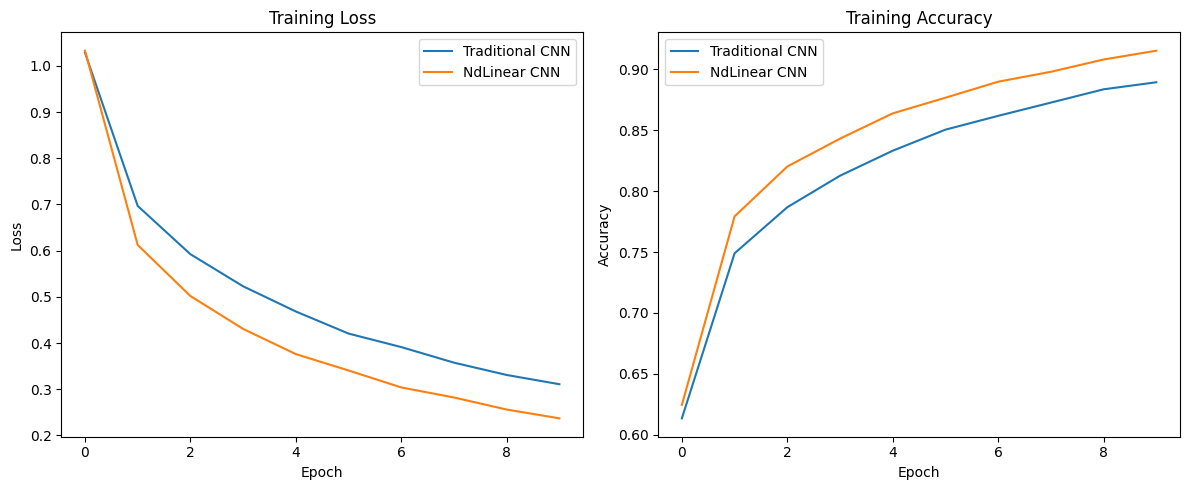

In [63]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trad_train_losses, label='Traditional CNN')
plt.plot(nd_train_losses, label='NdLinear CNN')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trad_train_accs, label='Traditional CNN')
plt.plot(nd_train_accs, label='NdLinear CNN')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparisions

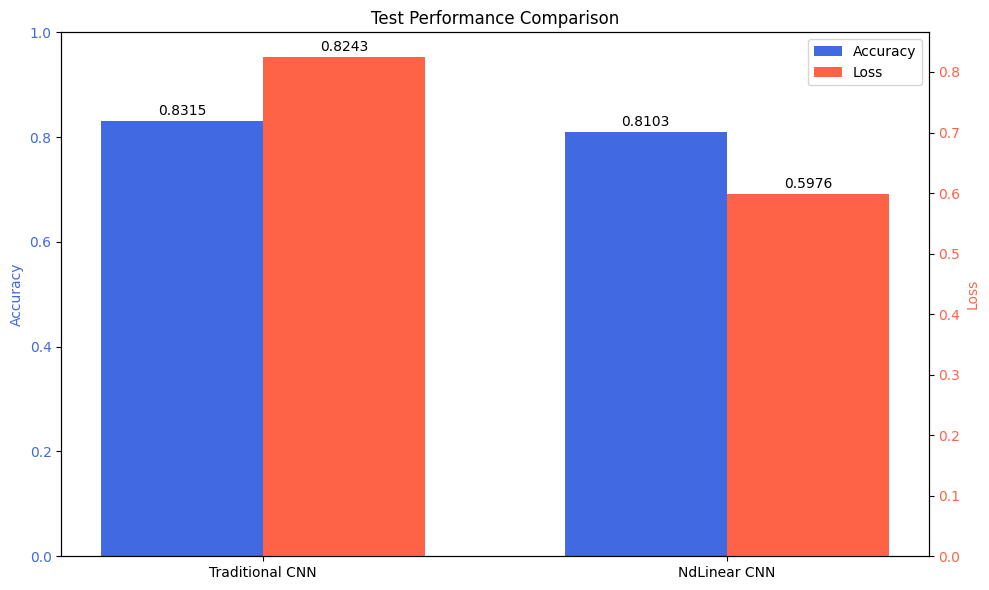


Results Comparison:
--------------------------------------------------
Model                Parameters      Test Accuracy   Test Loss 
-------------------- --------------- --------------- ----------
Traditional CNN      422,089         0.8315          0.8243    
NdLinear CNN         433,380         0.8103          0.5976    
-------------------- --------------- --------------- ----------
Difference           -11,291         -0.0212         0.2267    
Percentage           -2.68% worse


In [64]:
def plot_test_comparison():
    labels = ['Traditional CNN', 'NdLinear CNN']
    accuracies = [trad_test_acc, nd_test_acc]
    losses = [trad_test_loss, nd_test_loss]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot accuracy bars
    bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='royalblue')
    ax1.set_ylabel('Accuracy', color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')
    ax1.set_ylim(0, 1)
    
    # Create second y-axis for loss
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, losses, width, label='Loss', color='tomato')
    ax2.set_ylabel('Loss', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    
    # General plot settings
    ax1.set_title('Test Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    
    # Add value annotations
    for i, v in enumerate(accuracies):
        ax1.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')
    
    for i, v in enumerate(losses):
        ax2.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')
    
    # Add a legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_test_comparison()


print("\nResults Comparison:")
print("-"*50)
print(f"{'Model':<20} {'Parameters':<15} {'Test Accuracy':<15} {'Test Loss':<10}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*10}")
print(f"{'Traditional CNN':<20} {count_parameters(traditional_model):<15,} {trad_test_acc:<15.4f} {trad_test_loss:<10.4f}")
print(f"{'NdLinear CNN':<20} {count_parameters(ndlinear_model):<15,} {nd_test_acc:<15.4f} {nd_test_loss:<10.4f}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*10}")
print(f"{'Difference':<20} {count_parameters(traditional_model) - count_parameters(ndlinear_model):<15,} {nd_test_acc - trad_test_acc:<15.4f} {trad_test_loss - nd_test_loss:<10.4f}")
print(f"{'Percentage':<20} {100 * (1 - count_parameters(ndlinear_model) / count_parameters(traditional_model)):.2f}% {'better' if nd_test_acc > trad_test_acc else 'worse'}")
